# General Information
The BCI 2a dataset is one of the most used BCI motor imagery datasets in literature. It is a dataset with 22 EEG channels sampling at 250Hz. There are four target classes ['left', 'right', 'tongue', and 'foot']. In this tutorial, we will perform binary classification with left and right for simplicity. We will load, partition, filter, normalize, and segment the data. Once the data is preprocessed we will put it into a dataloader. Then, we will create a Separable Convolutional Neural Network, train the model (saving the best weights), and evaluate the model.

**Enabling GPU runtime (necessary)**

Before running this notebook, click edit in the top left, then click notebook settings. Click T4 GPU, then click save. This will enable a GPU runtime, which is needed for running our neural networks

Alternatively, you can click the drop down next to your session resources (located in the top right). Click change runtime time and select T4 GPU.

# Imports and configurations

In [2]:
import numpy as np
import pandas as pd
import torch
import scipy
from torch.utils.data import TensorDataset as TData
from torch.utils.data import DataLoader as DL
import matplotlib.pyplot as plt

In [3]:
# checks if cuda is available, then sets device to GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cpu')
    
device # should say cuda if gpu is enabled

device(type='cpu')

In [ ]:
# uncomment line below for GPU info
#!nvidia-smi

Wed Oct  2 22:16:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Steps to get dataset into colab environment**
1. Download the zipped file called "BCICIV_2a_all_patients.csv" from https://www.kaggle.com/datasets/aymanmostafa11/eeg-motor-imagery-bciciv-2a.

Then,
2. run the following cell and upload file stored locally

or

2. Upload the zip file to your google drive
3. Click the folder icon in the left panel and click the google drive icon to mount your drive to the colab notebook.

Finally,
4. Once you have done that, modify the below code by using the file path of the zip folder

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
! unzip "{}/BCICIV_2a_all_patients.csv.zip" # replace {} with your path

In [4]:
dataset = pd.read_csv("BCI_DATA/BCICIV_2a_all_patients.csv") # loading in the csv dataset with pandas

# Exploratory Data Analysis and Preprocessing

In [5]:
dataset.head() # first five rows

,patient,time,label,epoch,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,...,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16
0,1,-0.100,tongue,8,-1.681412,2.245496,-0.158350,1.163765,-1.523659,-0.575267,...,0.758116,3.441785,0.305517,1.137473,-1.275763,-2.898359,0.656704,-2.010063,-1.613804,-1.942455
1,1,-0.096,tongue,8,0.420417,0.587559,1.650510,0.970672,1.505904,0.891796,...,1.541586,-0.071620,0.258909,-1.448198,0.142472,-1.968405,-1.733655,-2.935578,-3.125256,-4.674610
2,1,-0.092,tongue,8,0.551365,1.499758,0.121302,2.859433,2.613414,4.636026,...,2.649097,-2.137938,-1.612096,-1.610218,-0.410173,-0.274957,-4.776535,-5.099551,-2.798995,-5.862021
3,1,-0.088,tongue,8,3.054916,-1.807238,1.843603,2.286812,5.995872,6.651295,...,6.031554,-5.249621,-2.672998,-3.452370,0.189081,1.593829,-6.081577,-5.476860,-2.932163,-6.874095
4,1,-0.084,tongue,8,2.506710,-2.453101,0.221178,0.127278,4.519931,6.249573,...,7.827097,-5.309546,-2.488783,-3.707608,1.447515,4.268278,-4.383690,-4.218426,-1.331932,-5.322692


In [6]:
# list of columns
print(dataset.columns, end='\n\n') # 22 eeg channels

# unique labels
print(dataset['label'].unique()) # 4 classes

# number of patients
print(dataset.patient.unique())

Index(['patient', 'time', 'label', 'epoch', 'EEG-Fz', 'EEG-0', 'EEG-1',
       'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz',
       'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12',
       'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'],
      dtype='object')

['tongue' 'foot' 'right' 'left']
[1 2 3 4 5 6 7 8 9]


In [6]:
# summary statistics
dataset.describe()

,patient,time,epoch,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,...,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16
count,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,...,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000,492048.000000
mean,5.058824,0.300000,312.133578,-0.811991,-0.399268,-0.669511,-0.908202,-0.607526,-0.325437,0.161790,...,0.204116,0.503087,0.305026,0.198725,0.255002,0.403190,0.741585,0.656315,0.618452,0.770249
std,2.645100,0.232092,176.757760,7.345682,5.758001,5.182636,5.864248,5.159808,5.475433,6.364779,...,6.205865,5.213024,3.651272,3.858260,3.715157,5.382023,5.700428,5.596708,5.853360,8.009687
min,1.000000,-0.100000,4.000000,-83.147212,-41.675317,-33.485423,-47.021740,-38.127339,-46.884049,-48.302710,...,-59.941901,-44.244171,-26.766605,-34.876342,-34.383536,-80.331997,-44.953972,-45.883926,-50.665326,-63.052646
25%,3.000000,0.100000,159.750000,-4.968283,-3.791030,-3.677560,-4.254897,-3.664436,-3.591620,-3.696852,...,-3.477809,-2.334381,-1.782227,-2.022270,-1.876298,-2.423160,-2.612049,-2.568257,-2.790032,-3.918116
50%,5.000000,0.300000,312.000000,-0.657985,-0.315676,-0.554353,-0.732763,-0.513890,-0.295103,0.155490,...,0.172776,0.518842,0.288530,0.194630,0.223781,0.400869,0.622900,0.544408,0.516750,0.615729
75%,7.000000,0.500000,465.000000,3.458858,3.057477,2.433318,2.581403,2.498685,2.943858,4.040869,...,3.859897,3.433846,2.412297,2.474890,2.396761,3.280874,4.007513,3.831749,3.953051,5.326128
max,9.000000,0.700000,656.000000,56.453337,51.751069,39.955918,40.397420,32.779037,38.145863,68.064016,...,67.502066,45.002544,40.933676,24.452903,25.866699,40.688767,42.318192,41.931835,45.042494,67.761316


In [7]:
# only interested in rows where target is left or right hand in this tutorial for simplicity
binary_mi = dataset.loc[(dataset['label'] == 'left') | (dataset['label'] == 'right')]
binary_mi.label.unique() # check that our row filter worked

array(['right', 'left'], dtype=object)

In [8]:
# get time period and check that it is constant throughout dataframe
t0 = binary_mi.time.iloc[:-1] # get time points except last one
t1 = binary_mi.time.iloc[1:] # series offest by one, so starting at 2nd time point until last
t0.reset_index(drop=True, inplace=True)
t1.reset_index(drop=True, inplace=True)

print(t0 - t1) # subtracting the two series to get time differences between adjacent time points
const_diff = ((t0 - t1 < -0.0039) & (t0 - t1 > -0.0041)) # checking that they are all around -0.004
const_diff[const_diff != True] # getting just the rows where time difference wasn't around -0.004

0        -0.004
1        -0.004
2        -0.004
3        -0.004
4        -0.004
          ...  
260490   -0.004
260491   -0.004
260492   -0.004
260493   -0.004
260494   -0.004
Name: time, Length: 260495, dtype: float64


200       False
401       False
602       False
803       False
1004      False
          ...  
259490    False
259691    False
259892    False
260093    False
260294    False
Name: time, Length: 1295, dtype: bool

In [9]:
print((t0 - t1)[200])
binary_mi.iloc[200:, 2] # time discrepancy seems to be caused by label change

0.7999999999999999


602       right
603        left
604        left
605        left
606        left
          ...  
491842    right
491843    right
491844    right
491845    right
491846    right
Name: label, Length: 260296, dtype: object

In [10]:
# don't care about time and epoch anymore
pruned_mi = binary_mi.drop(columns = ['time', 'epoch'])
pruned_mi.head()

,patient,label,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-C3,...,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16
402,1,right,-7.253367,-7.846816,-6.412021,-3.084196,0.023902,1.723496,-4.727450,-4.680500,...,3.113220,-0.901954,1.939467,2.611793,3.706669,3.466285,0.878394,2.311312,2.688791,2.039001
403,1,right,-5.988274,-7.314146,-3.828569,-3.821057,0.312432,-0.771177,-2.241655,-3.757205,...,3.987687,-0.027487,3.302215,1.923760,2.139730,2.143486,1.215752,1.867420,2.293727,1.497453
404,1,right,-5.113807,-3.558819,-2.026367,-3.874324,-1.010367,-2.435772,1.904297,-0.587816,...,4.032076,2.311824,3.004808,-0.277945,0.523963,-0.155874,1.504282,1.716496,0.873272,2.274264
405,1,right,-4.805302,-1.199533,-1.473722,-3.516991,-1.873737,-2.078439,3.970614,2.943346,...,1.069097,3.645720,3.508625,0.274701,-1.169485,-2.972369,2.935834,1.146095,0.058730,2.533941
406,1,right,-4.308143,-0.604718,-0.585937,-3.654597,-2.353140,-4.169171,6.372070,4.417067,...,-1.754056,4.826472,5.031175,-0.155874,-1.648888,-4.672476,3.530649,2.278020,-0.274189,1.468600


In [11]:
# get unique patients and labels
patients = binary_mi.patient.unique() # 1-9
labels = binary_mi.label.unique()     # left and right

In [12]:
left_hand = []
right_hand = []

# for each patient, get patient readings, convert to numpy array, and add
# to list corresponding to target (left or right)
for patient in patients:
  left_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'left')]
  right_df = pruned_mi[(pruned_mi['patient'] == patient) & (pruned_mi['label'] == 'right')]

  left_hand.append(left_df.iloc[:, 2:].to_numpy().T)
  right_hand.append(right_df.iloc[:, 2:].to_numpy().T)

right_hand[0].shape # shows shape of each list element

(22, 14472)

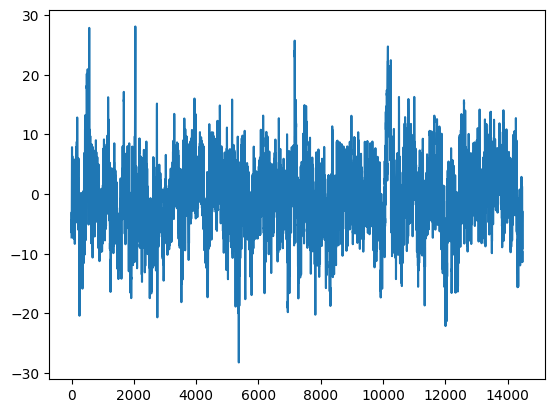

In [13]:
plt.plot(right_hand[0][0]) # visualizing first channel of first patient thinking of right hand motion

In [14]:
# get sequence length/length of each signal
left_len = left_hand[0].shape[1]
right_len = right_hand[0].shape[1]
# portion of sequence used for validation/testing set
left_eval_len = int(0.4 * left_hand[0].shape[1])
right_eval_len = int(0.4 * right_hand[0].shape[1])

# select random starting indexes for sub-sequences for validation and testing sets
left_hand_partition = np.random.randint(0, left_len - left_eval_len, len(left_hand))
right_hand_partition = np.random.randint(0, right_len - right_eval_len, len(right_hand))

# initialize lists to hold respective signals
left_train = []
left_val = []
left_test = []
right_train = []
right_val = []
right_test = []

# create training, validation, and testing sets for left hand signals
for i, num in enumerate(left_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + left_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  left_train.append(left_hand[i][:, list(range(num)) + list(range(upper_end, left_len))])
  # first half of subsequence used for validation
  left_val.append(left_hand[i][:, num:num+(left_eval_len//2)])
  # second half used for test set
  left_test.append(left_hand[i][:, num+(left_eval_len//2):num + left_eval_len])

# create training, validation, and testing sets for right hand signals
for i, num in enumerate(right_hand_partition):
  # get ending index of subsequence being cropped for validation and testing sets
  upper_end = num + right_eval_len
  # add portion of sequence excluding num:upper_end (portion used for evaluation)
  right_train.append(right_hand[i][:, list(range(num)) + list(range(upper_end, right_len))])
  # first half of subsequence used for validation
  right_val.append(right_hand[i][:, num:num+(right_eval_len//2)])
  # second half used for test set
  right_test.append(right_hand[i][:, num+(right_eval_len//2):num + right_eval_len])

# Signal Preprocessing

Now that the data is in the form of numpy arrays, we can start signal preprocessing

In [15]:
# function to bandpass filter signals
def bandpass_filter(signal, crit_freq = [5, 40], sampling_freq = 125):
  order = 4
  b, a = scipy.signal.butter(order, crit_freq, btype = 'bandpass', fs = sampling_freq)
  processed_signal = scipy.signal.filtfilt(b, a, signal, 1)
  return processed_signal

# segment a signal using sliding window technique, specifying sample frequency, window size, and window shift
def segmentation(signal, sampling_freq=125, window_size=1, window_shift=0.016):
  w_size = int(sampling_freq * window_size)
  w_shift = int(sampling_freq * window_shift)
  segments = []
  i = 0
  while i + w_size <= signal.shape[1]:
    segments.append(signal[:, i: i + w_size])
    i += w_shift
  return segments

# apply preprocessing steps in sequence to each signal
def preprocess(signals, crit_freq=[5,35], fs=250):
  preprocessed = []
  for signal in signals:
    # perform bandpass filter on each signal
    filtered_signal = bandpass_filter(signal, crit_freq, fs)
    # channel-wise z-score normalization
    normed_signal = (filtered_signal - filtered_signal.mean(1, keepdims=True)) / filtered_signal.std(1, keepdims=True)
    # segmentation of signals
    segments = segmentation(normed_signal, fs)
    # add signals to list
    preprocessed.extend(segments)
  return preprocessed

In [16]:
# generate preprocessed segments for training, validation, and testing
train_left = preprocess(left_train)
val_left = preprocess(left_val)
test_left = preprocess(left_test)
train_right = preprocess(right_train)
val_right = preprocess(right_val)
test_right = preprocess(right_test)

# print number of samples corresponding to left and right hand targets
print(f'left samples: {len(train_left) + len(val_left) + len(test_left)}, right samples: {len(train_right) + len(val_right) + len(test_right)}')
# print shape of each sample
print(f'segment shape: {train_left[0].shape}')

left samples: 30897, right samples: 30897
segment shape: (22, 250)


# Partitioning Dataset and Creating Data Loaders

In [17]:
# combine left and right signals to generate signal training, validation, and testing set
train_eeg = train_left + train_right
val_eeg = val_left + val_right
test_eeg = test_left + test_right
train_labels = [0 for i in range(len(train_left))] + [1 for i in range(len(train_right))]
val_labels = [0 for i in range(len(val_left))] + [1 for i in range(len(val_right))]
test_labels = [0 for i in range(len(test_left))] + [1 for i in range(len(test_right))]

In [23]:
# create torch tensor of zeros to hold data
train_eeg_tensor = torch.zeros((len(train_eeg), train_eeg[0].shape[0], train_eeg[0].shape[1]))
valid_eeg_tensor = torch.zeros((len(val_eeg), val_eeg[0].shape[0], val_eeg[0].shape[1]))
test_eeg_tensor = torch.zeros((len(test_eeg), test_eeg[0].shape[0], test_eeg[0].shape[1]))

# add each sample in train, validation, and test lists to appropriate tensor at correct index
for i in range(len(train_eeg)):
  tens = torch.from_numpy(train_eeg[i].copy())
  train_eeg_tensor[i] = tens
for i in range(len(val_eeg)):
  tens = torch.from_numpy(val_eeg[i].copy())
  valid_eeg_tensor[i] = tens
for i in range(len(test_eeg)):
  tens = torch.from_numpy(test_eeg[i].copy())
  test_eeg_tensor[i] = tens

# create zero tensor for one hot encoded labels
train_label_tensor = torch.zeros(len(train_labels), 2)
valid_label_tensor = torch.zeros(len(val_labels), 2)
test_label_tensor = torch.zeros(len(test_labels), 2)

# add labels to tensor at correct index
for i in range(len(train_labels)):
  label = train_labels[i]
  train_label_tensor[i][label] = 1
for i in range(len(val_labels)):
  label = val_labels[i]
  valid_label_tensor[i][label] = 1
for i in range(len(test_labels)):
  label = test_labels[i]
  test_label_tensor[i][label] = 1

# convert input, target tensors to Tensor Dataset from torch
train_ds = TData(train_eeg_tensor, train_label_tensor)
valid_ds = TData(valid_eeg_tensor, valid_label_tensor)
test_ds = TData(test_eeg_tensor, test_label_tensor)
# create dataloaders to hold batched data (batch size chosen was 64)
train_dl = DL(train_ds, batch_size=32, shuffle= True, drop_last = True)
valid_dl = DL(valid_ds, batch_size=32, shuffle= True, drop_last = True)
test_dl = DL(test_ds, batch_size=32, shuffle = True, drop_last = True)

print(train_dl.dataset.tensors[0].shape) # shape of input tensor

torch.Size([37962, 22, 250])


# Separable-Conv Model

This is a nice article describing separable convolutions https://www.analyticsvidhya.com/blog/2021/11/an-introduction-to-separable-convolutions/  
Main advantages
- smaller model, fewer parameters
- faster computation because of fewer multiplications  

Main disadvantage
- slightly lower accuracy

Here is the documentation for pytorch for reference https://pytorch.org/docs/stable/index.html

In [24]:
import torch
import torch.nn as nn

class CNNLSTMFeatureFusionModel(nn.Module):
    def __init__(self, in_channels, n_classes, hidden_units=50):
        super().__init__()

        # CNN branch
        self.conv1 = nn.Conv1d(in_channels, 16, kernel_size=125, padding='same')
        self.conv1_bn = nn.BatchNorm1d(16)
        self.pool1 = nn.AvgPool1d(4)

        self.separable_conv = nn.Sequential(
            nn.Conv1d(16, 16, kernel_size=3, groups=16, padding='same'),  # Depthwise
            nn.Conv1d(16, 24, kernel_size=1),  # Pointwise
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.AvgPool1d(8)
        )

        self.flatten_cnn = nn.Flatten()

        # LSTM branch
        self.lstm = nn.LSTM(input_size=22, hidden_size=50, batch_first=True)
        self.flatten_lstm = nn.Flatten()

        # Fully connected layer for fusion
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(218, n_classes)  # Updated input size

    def forward(self, x):
        # CNN branch
        cnn_out = self.conv1(x)
        cnn_out = self.conv1_bn(cnn_out)
        cnn_out = self.pool1(cnn_out)
        cnn_out = self.separable_conv(cnn_out)
        cnn_out = self.flatten_cnn(cnn_out)

        # LSTM branch
        lstm_input = x.permute(0, 2, 1)  # (batch, 250, 22)
        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = lstm_out[:, -1, :]  # Last time step’s output
        lstm_out = self.flatten_lstm(lstm_out)

        # Concatenate CNN and LSTM outputs
        fused_out = torch.cat((cnn_out, lstm_out), dim=1)

        # Apply dropout and final linear layer
        fused_out = self.dropout(fused_out)
        output = self.fc(fused_out)

        return output




# Example usage
fusion_model = CNNLSTMFeatureFusionModel(in_channels=22, n_classes=2).to(device)



In [48]:
del CNNLSTMFeatureFusionModel # only use when you want to delete and reinitialize the model

# Model training

In [ ]:
from tqdm.auto import tqdm
# using cross_entropy_loss
criterion = torch.nn.CrossEntropyLoss()
# using SGD optimizer for optimal convergence, even if slower
optimizer = torch.optim.Adam(fusion_model.parameters(), lr = 0.001, weight_decay=1e-5)
epochs = 100

train_losses = []
val_losses = []
accs = []
max_acc = 0
for i in range(epochs):
  total_train_loss = 0.0
  # set model to training mode
  fusion_model.train()
  # create progress bar
  pbar = tqdm(total=len(train_dl))
  for j, (sig, labels) in tqdm(enumerate(train_dl)):
    # add signal and label to cuda device
    sig = sig.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    # forward pass
    pred = fusion_model(sig)
    # loss evaluation
    loss = criterion(pred, labels)
    # backpropagation
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
    # update progress bar with running loss
    pbar.set_description(f"Epoch {i + 1}    loss={total_train_loss / (j + 1):0.4f}")
    pbar.update(1)
  pbar.close()
  train_losses.append(total_train_loss / len(train_dl))

  total_val_loss = 0.0
  total_accuracy = 0.0
  # set model to evaluation mode, which changes the behavior
  # of some layers like dropout and batch normalization
  fusion_model.eval()
  with torch.no_grad():
      # create progress bar
      pbar = tqdm(total=len(valid_dl))
      for j, (sig, labels) in enumerate(valid_dl):
          # send signal and label to cuda device
          labels = labels.to(device)
          # make prediction and evaluate loss
          pred = fusion_model(sig)
          loss = criterion(pred, labels)

          # perform softmax on output which is usually performed by loss automatically
          # this gives a probability vector
          prob_pred = torch.nn.functional.softmax(pred, -1)
          # compute accuracies by
          # 1. getting index of highest number (highest probability prediction)
          # 2. comparing the tensors element wise which gives boolean array comparing predictions to ground truth
          # 3. converting boolean array into array of 0s and 1s
          # 4. calculating mean with binary array, which gives (correct predictions) / (total predictions)
          acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          total_val_loss += loss.item()
          total_accuracy += acc.item()

          # update progress bar with val loss and accuracy
          pbar.set_description(f"val loss={total_val_loss / (j + 1):.4f}    val acc={total_accuracy / (j + 1):.4f}")
          pbar.update(1)
      print()
      pbar.close()
      val_losses.append(total_val_loss / len(valid_dl))
      accs.append(total_accuracy / len(valid_dl))

  # save model if accuracy is best seen
  if accs[-1] > max_acc:
    # dictionary with model state dict, optimizer state dict, and best accuracy
    checkpoint = {'state_dict': fusion_model.state_dict(), 'optimizer': optimizer.state_dict(), 'best_acc': accs[-1]}
    # save dictionary to specified file path if it exists or create new one otherwise
    torch.save(checkpoint, 'fusion_model.pth.tar')
    print('Model Saved')
    max_acc = accs[-1]

  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]


Model Saved


  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

# Model evaluation

In [21]:
# loading most accurate model
ckpt_dict = torch.load('fusion_model.pth.tar', weights_only=False)
fusion_model.load_state_dict(ckpt_dict['state_dict'])
# setting model to evaluation mode
fusion_model.eval()
test_accuracy = 0.0
test_loss = 0.0
with torch.no_grad():
      for signal, labels in test_dl:
          # send signal and label to cuda device
          signal = signal.to(device)
          labels = labels.to(device)
          # make prediction and evaluate loss
          pred = fusion_model(signal)
          loss = criterion(pred, labels)
          # compute probability vector and accuracy
          prob_pred = torch.nn.functional.softmax(pred, -1)
          acc = (prob_pred.argmax(-1) == labels.argmax(-1)).float().mean()
          test_loss += loss.item()
          test_accuracy += acc.item()

# display test set loss and accuracy
print(f'Test set    loss: {test_loss / len(test_dl):.4f}    accuracy: {test_accuracy / len(test_dl):.4f}')

Test set    loss: 0.9780    accuracy: 0.6887


Text(0, 0.5, 'cross entropy loss')

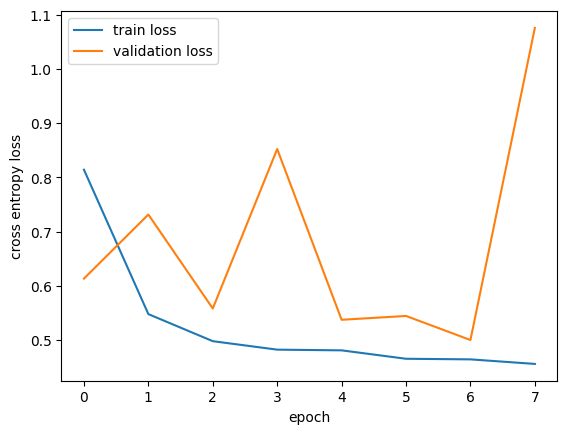

In [35]:
# plotting train and validation loss
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')

Text(0, 0.5, 'accuracy')

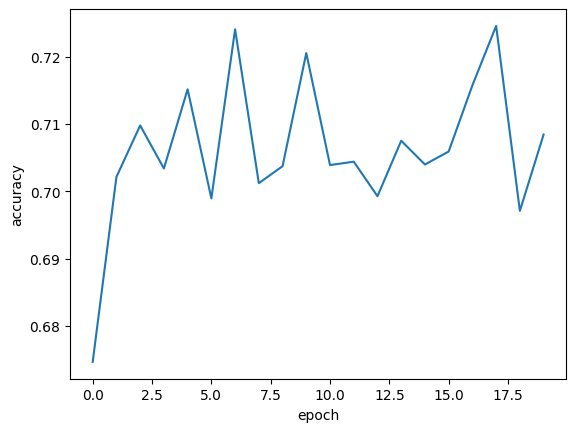

In [22]:
# plotting validation accuracy
plt.plot(accs)
plt.xlabel('epoch')
plt.ylabel('accuracy')

Further practice
- experiment with model architecture
  - try adding or deleting layers
  - fiddle with model and optimizer hyperparameters
    - change convolutional kernel size, stride, or dilation
    - change learning rate, momentum, weight decay, or
    use nesterov momentum
    - change to different optimizer
- create your own model or try transfer learning
- change batch size
- change train test split
- try implementing time series data augmentation techniques to generate synthetic training samples
- implement k-fold testing to get a more reliable measure of model performance
